# Table of content

* [Motivation](#motivation)
* [Simulation-based estimation](#simulation-based)
    * [Decision making assumption](#decision-making-assumption)
    * [Data assumption](#data-assumption)
    * [Run experiment](#run-experiment)
* [References](#references)

## Motivation <a class="anchor" id="motivation"></a>

People live in a world where many things are uncertain - i.e., the number of cars on the road at a particular time. As humans, we usually take uncertainty into account when making any decision. In addition, awaring the uncertainty helps people to make better decisions. In this notebook, we want to show how we can make better decisions with uncertainty.

Firstly, we will use **mortgage loan** as an use case to work on. Ultimately, we want to see the benefit of taking some risk; how much the expected profits would be? how much the uplift in terms of market size is?.

## Simulation-based approach <a class="anchor" id="simulation-based"></a>

Before simulating the outcome, we firstly need to make some assumptions about the data and how the decision maker make a decision.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy import stats
from tqdm import tqdm
from typing import Dict, Tuple
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"

In [22]:
# hyperparameter

SEED = 123

N_USER = 1_000
N_YEAR = 30
INTEREST_RATE = 0.06  # 6% per year
DEFAULT_RATE = 0.005  # 0.5%

### Decision making assumption <a class="anchor" id="decision-making-assumption"></a>

Let's say all customers **are not holding any debt**, and come to the bank intending to get loan with 30 years contract (Mortgage).

This is how the decision logic works:

* The customer has monthly salary $S$, and the maximum holding debt per customer is 40% of their salary [[4]](https://www.sansiri.com/content/view/%E0%B8%84%E0%B8%B3%E0%B9%81%E0%B8%99%E0%B8%B0%E0%B8%99%E0%B8%B3%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99-%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99-20,000-%E0%B8%A1%E0%B8%99%E0%B8%B8%E0%B8%A9%E0%B8%A2%E0%B9%8C%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B8%8B%E0%B8%B7%E0%B9%89%E0%B8%AD%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99%E0%B9%84%E0%B8%94%E0%B9%89%E0%B8%81%E0%B8%B5%E0%B9%88%E0%B8%A5%E0%B9%89%E0%B8%B2%E0%B8%99/th).

* As we assume the customer are not holding any debt, the installment will be $I = S * 0.4$.

* If installment is less than minimum mortgage payment, deny the loan.

**Mortgage payment per month** [[9]](https://www.bankrate.com/mortgages/mortgage-calculator/)

$$
M = P\frac{r(1+r)^n}{(1+r)^n - 1}
$$

Where, 

$M$ is the monthly payment

$P$ is the mortgage amount

$r$ is the monthly interest rate

$n$ is the number of payment

</br>

**Maximum mortgage amount**

$$
P = M\frac{(1+r)^n - 1}{r(1+r)^n}
$$

where, $M = I = S * 0.4$

In [23]:
def calculate_mortgage_payment_per_month(p: float, r: float, n: int = 360) -> float:
    """
    Calcuate the mortgage payment per month
    
    Args:
        p: mortgage amount
        r: monthly interest rate
        n: number of payment (default 360)
        
    Returns:
        monthly per month
    """
    
    numerator = r * (1 + r) ** n
    denominator = (1 + r) ** n - 1
    res = p * numerator / denominator
    return res


def calculate_maximum_mortgage_amount(s: float, r: float, n: int = 360) -> float:
    """
    Calculate the maximum mortgage allowance
    
    Args:
        s: salary/income
        r: monthly interest rate
        n: number of payment (default 360)
        
    Returns:
        the maximum mortgage allowance
    """
    
    numerator = (1 + r) ** n - 1
    denominator = r * (1 + r) ** n
    m = s * 0.4
    res = m * numerator / denominator
    return res

### Data assumption <a class="anchor" id="data-assumption"></a>

#### Customer income

In this variable, we assume the distribution of the income is come from one of the postively skewed distribution family - e.g., log-normal, gamma, skewed-normal distribution. In addition, we assume the mean of the income is around 20,000 THB based on [[8]](https://www.wongnai.com/articles/cost-of-living?ref=ct) blog. 

In [24]:
def generate_income(n: int, seed: int = SEED, method: str = "lognorm") -> np.ndarray:
    dist = None
    if method == "lognorm":
        dist = stats.lognorm(0.7)
    elif method == "gamma":
        dist = stats.gamma(1)
    elif method == "skewnorm":
        dist = stats.skewnorm(10)
    else:
        raise NotImplementedError(f"{method} method is not implemented.")
    
    rvs = dist.rvs(size=n, random_state=seed)
    
    # scale up the random samples
    res = rvs * 20_000 / np.mean(rvs)
    
    return res

<!-- The figure below shows the distribution of the income in the different type of distributions. -->

In [25]:
# fig, ax = plt.subplots(figsize=(10, 7))

# for dist_name in ["gamma", "skewnorm", "lognorm"]:
#     _ = sns.distplot(generate_income(N_USER, SEED, dist_name), ax=ax, label=dist_name)
# _ = plt.legend()
# _ = plt.xlabel("Income")

In [26]:
# assume the customer's income distribution is the log-normal distribution.
cust_income = generate_income(N_USER, SEED, "lognorm")

# bining the income
income_bin_names = ["<= 8,000", "(8,000 -> 15,000]", "(15,000 -> 30,000]", "(30,000 -> 50,000]", "> 50,000"]
cust_income_bin = pd.cut(cust_income, bins=[-np.inf, 8_000, 15_000, 30_000, 50_000, np.inf], labels=income_bin_names)

/var/folders/gj/v35wy9nj527cdsy8fkvw3fjh0000gq/T/ipykernel_2456/4291546690.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  _ = sns.distplot(cust_income, ax=ax[0])


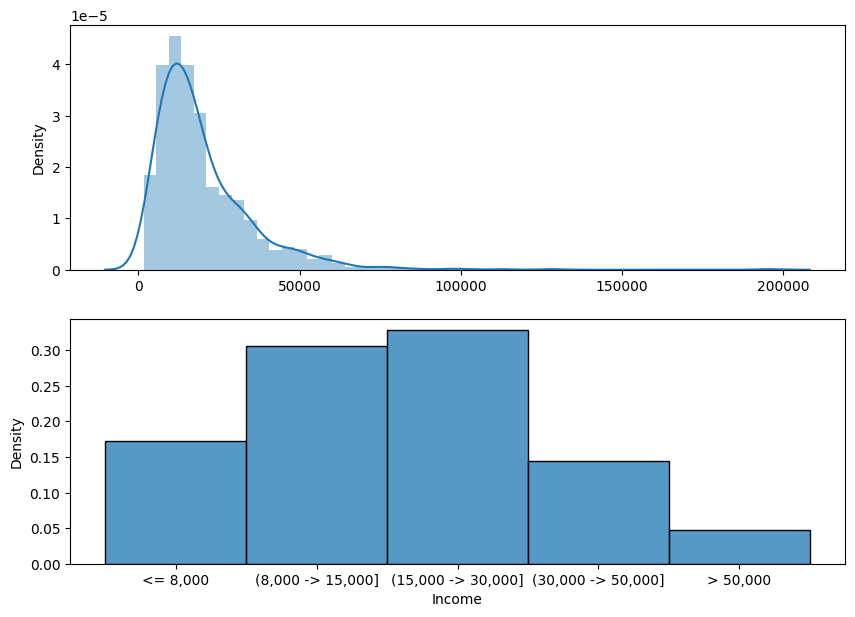

In [27]:
fig, ax = plt.subplots(nrows=2, figsize=(10, 7))
_ = sns.distplot(cust_income, ax=ax[0])
_ = sns.histplot(cust_income_bin, ax=ax[1], stat='density')
_ = plt.xlabel("Income")

#### Default rate

In order to make the assumption simpler, we assume all the income buckets use the same default rate.

In [28]:
cust_default = stats.bernoulli(DEFAULT_RATE).rvs(size=N_USER, random_state=SEED)

#### Customer expected pay (%)

We believe most customers are able to payback all loan, but some customer might not, it could be many reasons such as refinance. 

In [29]:
def generate_customer_payback_ability(n: int, seed: int = SEED):
    dist = stats.lognorm(0.7)
    rvs = dist.rvs(size=n, random_state=seed)
    res = 1 - ((rvs - rvs.min()) / (rvs.max() - rvs.min()))
    
    return res

In [30]:
np.percentile(generate_customer_payback_ability(1_000), [50, 60, 70, 80, 90])

array([0.92819194, 0.94025653, 0.9521959 , 0.9638491 , 0.97590852])

/var/folders/gj/v35wy9nj527cdsy8fkvw3fjh0000gq/T/ipykernel_2456/2339788166.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(generate_customer_payback_ability(1_000))


<AxesSubplot: ylabel='Density'>

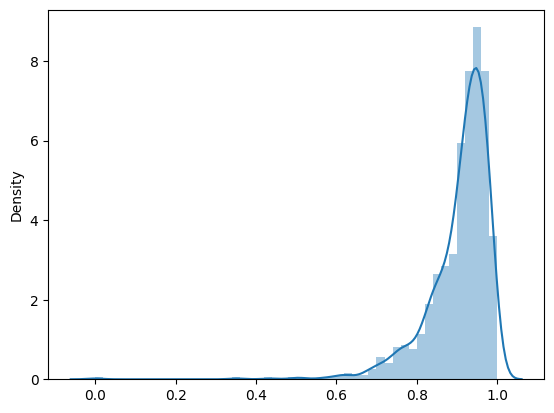

In [31]:
sns.distplot(generate_customer_payback_ability(1_000))

In [32]:
cust_payback_ability = generate_customer_payback_ability(1_000, SEED)

#### Expected profit 

We assume that customer will take the maximum mortgage allowance. So, profit is the different between total payment and maximum mortgage allowance.

In [33]:
# calculate the maximum mortgage allowance
cust_max_mortgage_allowance = np.array(list(map(lambda inc: calculate_maximum_mortgage_amount(inc, INTEREST_RATE / 12), cust_income)))

cust_total_payment = np.array(list(map(lambda p: calculate_mortgage_payment_per_month(p, INTEREST_RATE / 12), cust_max_mortgage_allowance))) * N_YEAR * 12

expected_profit = cust_total_payment - cust_max_mortgage_allowance

#### Model confidence

As we know the proxy-income model [[10]](https://scbcorp.sharepoint.com/:p:/r/teams/DATAXProducts/Shared%20Documents/General/Project(s)/%5BCardX%5D%20Income%20Proxy/weekly_meeting/prxy_incm_2022-12-06.pptx?d=we06d5a4e46b64b5a946f44e43925c1e4&csf=1&web=1&e=UzMZha) performs poorly on class 0 (<= 8,000) and 4 (> 50,000), so we assume the confidence level parameter for these two classes  will always be the lowest.



In [99]:
model_conf_levels = {
    bin_name: conf for bin_name, conf in zip(income_bin_names, [0.1, 0.5, 0.5, 0.1, 0.5])
}

model_conf_levels

{'<= 8,000': 0.1,
 '(8,000 -> 15,000]': 0.5,
 '(15,000 -> 30,000]': 0.5,
 '(30,000 -> 50,000]': 0.1,
 '> 50,000': 0.5}

In [100]:
model_conf = cust_income_bin.map(model_conf_levels)

#### Model prediction

In [101]:
def norm_output(xs: np.ndarray) -> np.ndarray:
    """
    Normalize the vector to sum up to 1
    
    Args:
        xs: logits output
        
    Returns:
        normalized output
    """
    
    norm_xs = xs / xs.sum()
    return norm_xs


def calculate_entropy(xs: np.ndarray) -> float:
    """
    Calculate entropy of the prediction.
    
    Args:
        xs: normalized output
        
    Returns:
        the entropy
    """
    
    ent = - (xs * np.log2(xs)).sum()
    return ent

In [102]:
def random_prediction_wrt_entropy(upper_ent: float, rng) -> Tuple[np.ndarray, int]:
    """
    Random model prediction with respect to entropy.
    
    Args:
        upper_ent: upper bound of entropy
        rng: random generator
        
    Returns:
        model probability and number of sample time.
    """
    
    i = 0
    while True:
        pred = rng.uniform(size=5)
        norm_pred = norm_output(pred)
        ent = calculate_entropy(norm_pred)
        i += 1
        if ent < upper_ent:
            return norm_pred, i

        
def get_probs_from_target_class(class_idx: int, upper_ent: float, rng) -> np.ndarray:
    probs, _ = random_prediction_wrt_entropy(upper_ent, rng)
    max_idx = probs.argmax()
    probs[max_idx], probs[class_idx] = probs[class_idx], probs[max_idx]  # swap
    return probs

In [103]:
def generate_model_prediction(seed: int) -> np.ndarray:
    rng = np.random.default_rng(seed)
    res = []
    for income_bin, conf in tqdm(list(zip(cust_income_bin, model_conf))):
        true_idx = income_bin_names.index(income_bin)
        if rng.uniform() <= conf:
            probs = get_probs_from_target_class(true_idx, 1.0, rng)
        else:
            probs = get_probs_from_target_class(rng.choice(range(5)), 1.0, rng)
        res.append(probs)
    return np.array(res)

In [104]:
model_preds = generate_model_prediction(SEED)

100%|███████████████████████████████████████| 1000/1000 [00:25<00:00, 39.86it/s]


#### Construct the data

In [105]:
cust_df = pd.DataFrame({
    "cust_income": cust_income,
    "cust_income_bin": cust_income_bin,
    "cust_default": cust_default,
    "cust_max_mortgage_allowance": cust_max_mortgage_allowance,
    "cust_total_payment": cust_total_payment,
    "expected_profit": expected_profit,
})

cust_df.head()

,cust_income,cust_income_bin,cust_default,cust_max_mortgage_allowance,cust_total_payment,expected_profit
0,7536.551066,"<= 8,000",0,5.028134e+05,1.085263e+06,5.824499e+05
1,32389.940430,"(30,000 -> 50,000]",0,2.160948e+06,4.664151e+06,2.503203e+06
2,19644.374848,"(15,000 -> 30,000]",0,1.310607e+06,2.828790e+06,1.518183e+06
3,5614.203813,"<= 8,000",0,3.745608e+05,8.084453e+05,4.338845e+05
4,10747.636877,"(8,000 -> 15,000]",0,7.170463e+05,1.547660e+06,8.306134e+05


In [106]:
preds = pd.DataFrame(model_preds, columns=income_bin_names)
preds["pred"] = list(map(lambda x: income_bin_names[x], model_preds.argmax(axis=1)))

preds.head()

,"<= 8,000","(8,000 -> 15,000]","(15,000 -> 30,000]","(30,000 -> 50,000]","> 50,000",pred
0,0.037813,0.009785,0.905972,0.027907,0.018523,"(15,000 -> 30,000]"
1,0.880972,0.030698,0.047053,0.013437,0.027840,"<= 8,000"
2,0.139174,0.796960,0.010573,0.042527,0.010766,"(8,000 -> 15,000]"
3,0.847870,0.036641,0.042973,0.059543,0.012973,"<= 8,000"
4,0.015855,0.000388,0.030536,0.182340,0.770881,"> 50,000"


In [107]:
from sklearn.metrics import classification_report, confusion_matrix

In [108]:
confusion_matrix(cust_df["cust_income_bin"], preds["pred"], labels=income_bin_names)

array([[ 58,  34,  27,  34,  20],
       [ 24, 189,  31,  24,  38],
       [ 34,  42, 203,  26,  23],
       [ 20,  26,  25,  40,  34],
       [  8,   6,   3,   1,  30]])

In [109]:
print(classification_report(cust_df["cust_income_bin"], preds["pred"], labels=income_bin_names))

                    precision    recall  f1-score   support

          <= 8,000       0.40      0.34      0.37       173
 (8,000 -> 15,000]       0.64      0.62      0.63       306
(15,000 -> 30,000]       0.70      0.62      0.66       328
(30,000 -> 50,000]       0.32      0.28      0.30       145
          > 50,000       0.21      0.62      0.31        48

          accuracy                           0.52      1000
         macro avg       0.45      0.49      0.45      1000
      weighted avg       0.55      0.52      0.53      1000



In [110]:
(preds["pred"] == cust_df["cust_income_bin"]).mean()

0.52

### Run experiment <a class="anchor" id="run-experiment"></a>

In [22]:
def calculate_expected_outcome(df: pd.DataFrame, risk_threshold: float) -> Dict:
    accepted_cust = df[df["cust_income_conf"] >= risk_threshold].copy()
    rejected_cust = df[df["cust_income_conf"] < risk_threshold].copy()
    
    accepted_fraud = accepted_cust[accepted_cust["cust_fraud"] == 1].copy()
    accepted_non_fraud = accepted_cust[accepted_cust["cust_fraud"] != 1].copy()
    
    rejected_fraud = rejected_cust[rejected_cust["cust_fraud"] == 1].copy()
    rejected_non_fraud = rejected_cust[rejected_cust["cust_fraud"] != 1].copy()
    
    expected_revenue = (accepted_non_fraud["expected_profit"]).mean()
    expected_loss = (accepted_fraud["cust_max_mortgage_allowance"]).mean()
    expected_opportunity_revenue_loss = (rejected_non_fraud["expected_profit"]).mean()
    expected_opportunity_loss_loss = (rejected_non_fraud["cust_max_mortgage_allowance"]).mean()

    accept_rate = accepted_cust.shape[0] / df.shape[0]
    
    return dict(
        expected_profit=expected_revenue - expected_loss,
        expected_revenue=expected_revenue,
        expected_loss=expected_loss,
        expected_opportunity_profit_loss=expected_opportunity_revenue_loss - expected_opportunity_loss_loss,
        accept_rate=accept_rate
    )
    

def run_simulation(risk_threshold: float, seed: int):
    
    # generate customer income
    cust_income = generate_income(N_USER, seed, "lognorm")
    cust_income_bin = pd.cut(cust_income, bins=[-np.inf, 8_000, 15_000, 30_000, 50_000, np.inf], labels=income_bin_names)
    
    # model confidence
    model_conf_levels = {
        bin_name: conf for bin_name, conf in zip(income_bin_names, sample_conf_level(seed))
    }
    cust_income_conf = cust_income_bin.map(model_conf_levels).astype(float)
    
    # fraud
    cust_fraud = stats.bernoulli(FRAUD_RATE).rvs(size=N_USER, random_state=seed)
    
    # profit
    cust_max_mortgage_allowance = np.array(list(map(lambda inc: calculate_maximum_mortgage_amount(inc, INTEREST_RATE / 12), cust_income)))
    cust_total_payment = np.array(list(map(lambda p: calculate_mortgage_payment_per_month(p, INTEREST_RATE / 12), cust_max_mortgage_allowance))) * N_YEAR * 12
    expected_profit = cust_total_payment - cust_max_mortgage_allowance
    
    # construct dataframe
    cust_df = pd.DataFrame({
        "cust_income": cust_income,
        "cust_income_bin": cust_income_bin,
        "cust_income_conf": cust_income_conf,
        "cust_fraud": cust_fraud,
        "cust_max_mortgage_allowance": cust_max_mortgage_allowance,
        "cust_total_payment": cust_total_payment,
        "expected_profit": expected_profit,
    })
    
    outcome = calculate_expected_outcome(cust_df, risk_threshold)
    
    return outcome, cust_df

In [23]:
tmp = pd.DataFrame()

# for risk_threshold in np.linspace(0, 1, 20):
for risk_threshold in [0.2, 0.5, 0.7, 0.9]:

    res = []

    for i in range(500):
        outcome, _ = run_simulation(risk_threshold, i)
        res.append(outcome)
    
    t = pd.DataFrame(res)
    t["risk_threshold"] = risk_threshold
    
    tmp = tmp.append(t)

tmp = tmp.reset_index(drop=True)

/var/folders/gj/v35wy9nj527cdsy8fkvw3fjh0000gq/T/ipykernel_2879/2387370420.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(t)
/var/folders/gj/v35wy9nj527cdsy8fkvw3fjh0000gq/T/ipykernel_2879/2387370420.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(t)
/var/folders/gj/v35wy9nj527cdsy8fkvw3fjh0000gq/T/ipykernel_2879/2387370420.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(t)
/var/folders/gj/v35wy9nj527cdsy8fkvw3fjh0000gq/T/ipykernel_2879/2387370420.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  tmp = tmp.append(t)


In [24]:
tmp

,expected_profit,expected_revenue,expected_loss,expected_opportunity_profit_loss,accept_rate,risk_threshold
0,234354.930532,1.550767e+06,1.316412e+06,NaN,1.0000,0.2
1,211427.424522,1.762522e+06,1.551095e+06,60756.328849,0.8312,0.2
2,241801.720012,1.552489e+06,1.310687e+06,NaN,1.0000,0.2
3,220898.658801,1.542978e+06,1.322080e+06,215870.552210,0.7832,0.2
4,195283.271521,1.542021e+06,1.346737e+06,NaN,1.0000,0.2
...,...,...,...,...,...,...
1995,NaN,NaN,NaN,211722.945521,0.0000,0.9
1996,412484.163554,2.894705e+06,2.482221e+06,184566.053439,0.1281,0.9
1997,NaN,NaN,NaN,210693.055230,0.0000,0.9
1998,139538.368100,1.272979e+06,1.133440e+06,281049.579084,0.6584,0.9


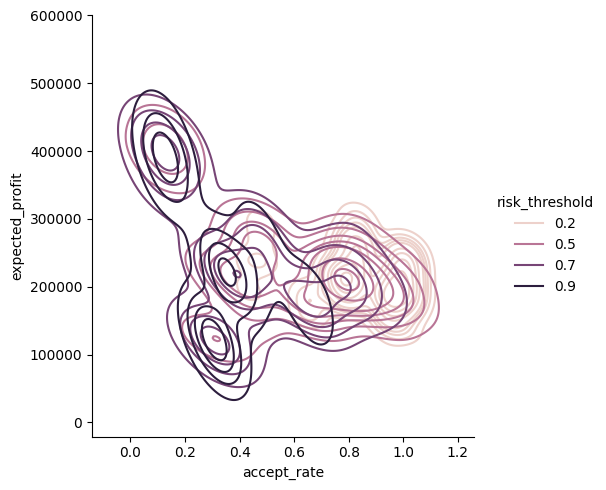

In [53]:
sns.displot(data=tmp, x="accept_rate", y="expected_profit", hue="risk_threshold", kind="kde")

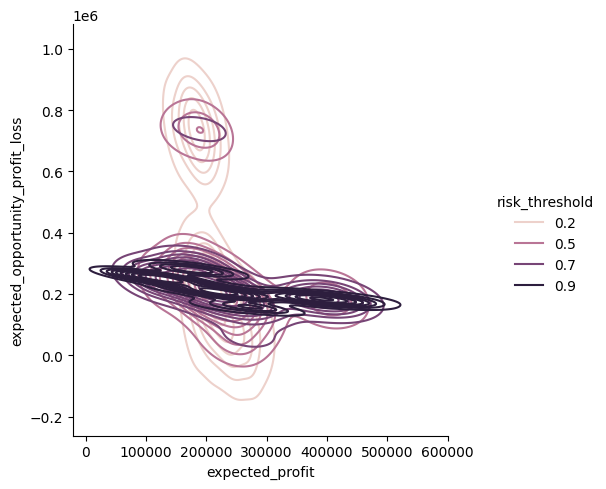

In [49]:
# _ = sns.displot(data=tmp, x="expected_revenue", y="expected_loss", hue="risk_threshold", kind='kde')
# _ = sns.boxplot(data=tmp, x="risk_threshold", y="expected_profit")
# _ = sns.boxplot(data=tmp, x="risk_threshold", y="expected_opportunity_profit_loss")
_ = sns.displot(data=tmp, x="expected_profit", y="expected_opportunity_profit_loss", hue="risk_threshold", kind='kde')

## References <a class="anchor" id="references"></a>

1. [Risk-Based Customer Segmentation within Banking](https://medium.com/ibm-data-ai/risk-based-customer-segmentation-within-banking-6109b1104f20)
2. [A Gentle Introduction to Data Science for Credit Risk Modeling](https://mlopshowto.com/an-intro-to-data-science-for-credit-risk-modelling-57935805a911)
3. [Proportion Of Loan Balances To Loan Amounts Is Too High](https://www.sensibledollar.com/proportion-of-loan-balances-to-loan-amounts-is-too-high/)
4. [เงินเดือน 20,000 มนุษย์เงินเดือนกู้เงินซื้อบ้านได้กี่ล้าน
](https://www.sansiri.com/content/view/%E0%B8%84%E0%B8%B3%E0%B9%81%E0%B8%99%E0%B8%B0%E0%B8%99%E0%B8%B3%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99-%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99-20,000-%E0%B8%A1%E0%B8%99%E0%B8%B8%E0%B8%A9%E0%B8%A2%E0%B9%8C%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B9%80%E0%B8%94%E0%B8%B7%E0%B8%AD%E0%B8%99%E0%B8%81%E0%B8%B9%E0%B9%89%E0%B9%80%E0%B8%87%E0%B8%B4%E0%B8%99%E0%B8%8B%E0%B8%B7%E0%B9%89%E0%B8%AD%E0%B8%9A%E0%B9%89%E0%B8%B2%E0%B8%99%E0%B9%84%E0%B8%94%E0%B9%89%E0%B8%81%E0%B8%B5%E0%B9%88%E0%B8%A5%E0%B9%89%E0%B8%B2%E0%B8%99/th)
5. [Monte Carlo Simulation with Python](https://pbpython.com/monte-carlo.html)
6. [Personal Loan Statistics for 2022](https://www.fool.com/the-ascent/research/personal-loan-statistics/)
7. [Value at risk](https://en.wikipedia.org/wiki/Value_at_risk)
8. [เงินเดือนเท่านี้ ไหวไหม? เทียบค่าครองชีพกับเงินเดือนของแต่ละประเทศ](https://www.wongnai.com/articles/cost-of-living?ref=ct)
9. [Mortgage Calculator](https://www.bankrate.com/mortgages/mortgage-calculator/)
10. [Proxy Income Model - weekly update (06-12-2022)](https://scbcorp.sharepoint.com/:p:/r/teams/DATAXProducts/_layouts/15/Doc.aspx?sourcedoc=%7BE06D5A4E-46B6-4B5A-946F-44E43925C1E4%7D&file=prxy_incm_2022-12-06.pptx&action=edit&mobileredirect=true)
11. [Home Loan Calculator](https://loan-calculators.org/home)